In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.alpha"] = 0.5

# Aliasing: Different Signals, Identical Samples

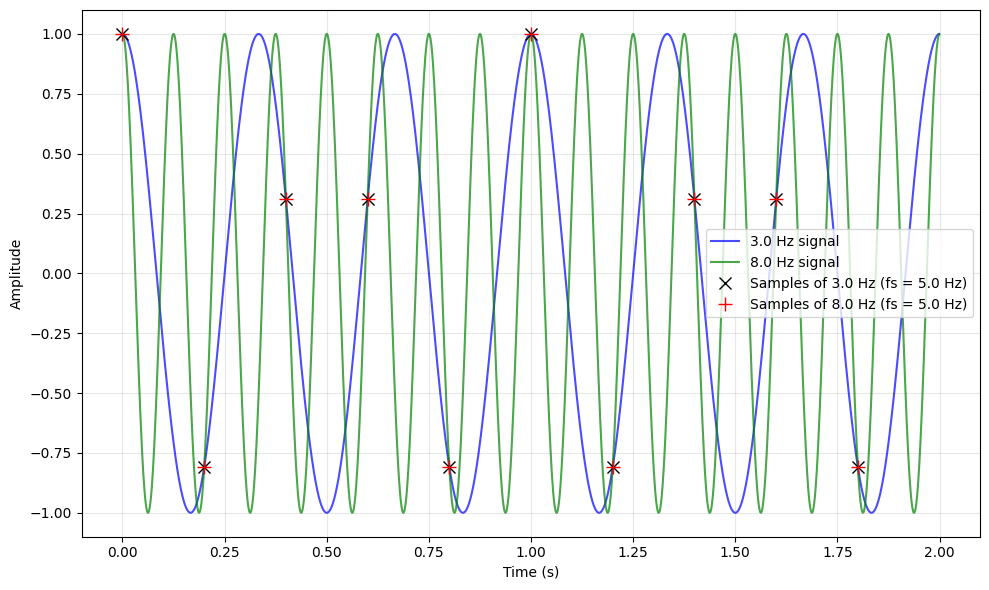

In [2]:
LOW_FREQ_HZ = 3.0
HIGH_FREQ_HZ = 8.0
SAMPLING_RATE_HZ = 5.0
SIGNAL_DURATION_S = 2.0
CONTINUOUS_RATE_HZ = 1000.0

continuous_time_s = np.arange(0.0, SIGNAL_DURATION_S, 1.0 / CONTINUOUS_RATE_HZ)
low_freq_signal = np.cos(2 * np.pi * LOW_FREQ_HZ * continuous_time_s)
high_freq_signal = np.cos(2 * np.pi * HIGH_FREQ_HZ * continuous_time_s)

sample_times_s = np.arange(0.0, SIGNAL_DURATION_S, 1.0 / SAMPLING_RATE_HZ)
sample_interval = int(CONTINUOUS_RATE_HZ / SAMPLING_RATE_HZ)
sample_indices = np.arange(0, len(continuous_time_s), sample_interval)
low_freq_samples = low_freq_signal[sample_indices]
high_freq_samples = high_freq_signal[sample_indices]

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(continuous_time_s, low_freq_signal, 'b-', alpha=0.7, 
        label=f'{LOW_FREQ_HZ} Hz signal')
ax.plot(continuous_time_s, high_freq_signal, 'g-', alpha=0.7, 
        label=f'{HIGH_FREQ_HZ} Hz signal')
ax.plot(sample_times_s, low_freq_samples, 'kx', markersize=8, 
        label=f'Samples of {LOW_FREQ_HZ} Hz (fs = {SAMPLING_RATE_HZ} Hz)')
ax.plot(sample_times_s, high_freq_samples, 'r+', markersize=10, 
        label=f'Samples of {HIGH_FREQ_HZ} Hz (fs = {SAMPLING_RATE_HZ} Hz)')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Amplitude')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In this example, two different cosines (3 Hz and 8 Hz) sampled at 5 Hz produce the same discrete samples, so we can’t tell them apart from the sampled data alone. This illustrates aliasing: if the sampling rate is too low, the samples no longer uniquely determine the original signal.

Sampling a continuous signal is mathematically equivalent to multiplying it by a sampling function. This sampling function is a train of Dirac delta functions (impulses) spaced at intervals of $T_s = \frac{1}{f_s}$:
$$s(t) = \sum_{n=-\infty}^{\infty} \delta(t - nT_s)$$
where $f_s$ is the sampling rate.

The fourier transform of the sampling function is:

$$
S(f) = \int_{-\infty}^{\infty} \left(\sum_{n=-\infty}^{\infty} \delta(t - nT_s)\right) e^{-i 2\pi f t}\, dt
$$

$$
S(f) = \sum_{n=-\infty}^{\infty} \int_{-\infty}^{\infty} \delta(t - nT_s)\, e^{-i 2\pi f t}\, dt
$$

Using the shifting property of the dirac:
$$
\int_{-\infty}^{\infty} \delta(t - nT_s)\, e^{-i 2\pi f t}\, dt
= e^{-i 2\pi f (nT_s)}
$$

We have

$$
S(f) = \sum_{n=-\infty}^{\infty} e^{-i 2\pi f n T_s}
$$

Using the Poisson summation identity:

$$
\sum_{n=-\infty}^{\infty} e^{-i 2\pi f n T_s}
= \frac{1}{T_s} \sum_{k=-\infty}^{\infty} \delta\!\left(f - k f_s\right)
$$

Therefore:

$$
S(f) = \frac{1}{T_s} \sum_{k=-\infty}^{\infty} \delta\!\left(f - k f_s\right)
$$

The result indicates that sampling a signal in the time domain leads to periodic repetitions of its spectrum in the frequency domain, since multiplying in time corresponds to convolution in frequency


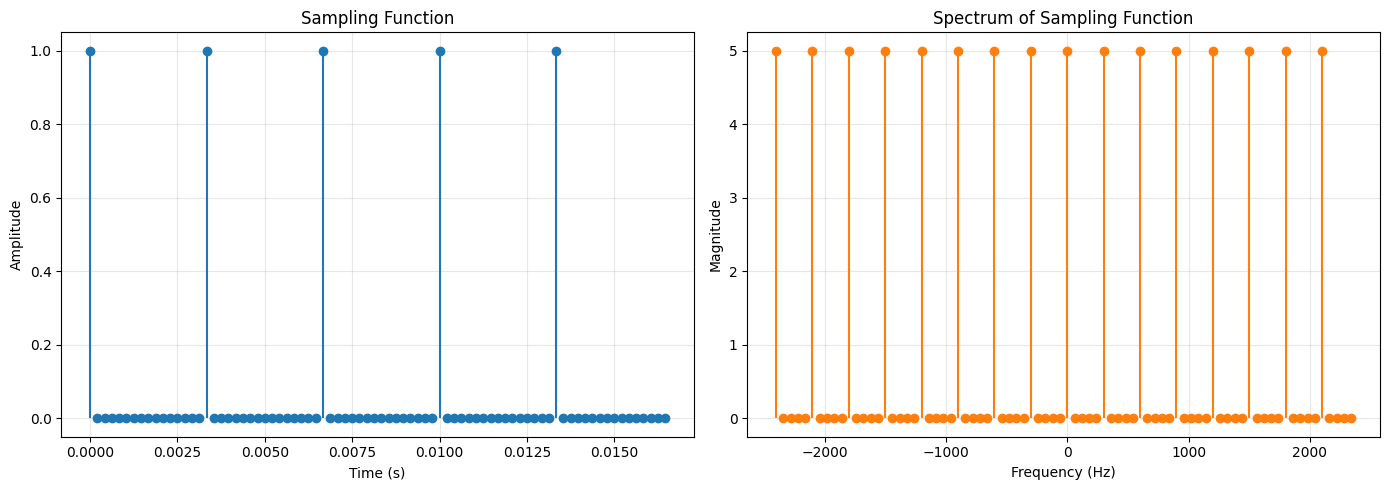

In [4]:
SAMPLING_RATE_HZ = 300.0
NUM_SAMPLE_PERIODS = 5
SIGNAL_DURATION_S = NUM_SAMPLE_PERIODS / SAMPLING_RATE_HZ
CONTINUOUS_RATE_HZ = 4800.0

continuous_time_s = np.arange(0.0, SIGNAL_DURATION_S, 1.0 / CONTINUOUS_RATE_HZ)
sampling_function = np.zeros_like(continuous_time_s)
sample_times_s = np.arange(0.0, SIGNAL_DURATION_S, 1.0 / SAMPLING_RATE_HZ)
sample_indices = np.round(sample_times_s * CONTINUOUS_RATE_HZ).astype(int)
sampling_function[sample_indices] = 1.0

sampling_spectrum = np.fft.fft(sampling_function)
sampling_freqs_hz = np.fft.fftfreq(len(sampling_function), d=1.0 / CONTINUOUS_RATE_HZ)
sampling_spectrum_shifted = np.fft.fftshift(sampling_spectrum)
sampling_freqs_shifted_hz = np.fft.fftshift(sampling_freqs_hz)
sampling_spectrum_mag = np.abs(sampling_spectrum_shifted)

fig, (ax_time, ax_freq) = plt.subplots(1, 2, figsize=(14, 5))

ax_time.stem(continuous_time_s, sampling_function, basefmt=' ', linefmt='C0-')
ax_time.set_xlabel('Time (s)')
ax_time.set_ylabel('Amplitude')
ax_time.set_title('Sampling Function')
ax_time.grid(True, alpha=0.3)

ax_freq.stem(sampling_freqs_shifted_hz, sampling_spectrum_mag, basefmt=' ', linefmt='C1-')
ax_freq.set_xlabel('Frequency (Hz)')
ax_freq.set_ylabel('Magnitude')
ax_freq.set_title('Spectrum of Sampling Function')
ax_freq.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()